## Overdispersion estimation from the cluster size distributions outside China

## Background
A novel coronavirus disease (COVID-19) outbreak, which is considered to have been originated from the wildlife market in Wuhan, China, has now been affecting a number of countries worldwide. Substantial amount of human-to-human transmisisons were observed in China and other countries; the basic reproduction number $R_0$ (the average number of secondary transmissions caused by a single primary case) has been estimated around 2-3. However, there are a few countries where a number of imported cases were ascertained but have not seen as many secondary cases as one might expect from the $R_0$ above one.

This suggests that not all symptomatic cases cause a secondary transmission, which was also suggested in the past coronavirus outbreaks (SARS/MERS). Such high variation in the distribution of the number of secondary transmissions (offspring distribution), often characterised by the overdispersion parameter $k$ of the negative binomial distribution, is critical information in the epidemic control strategy. High overdispersion in the offspring distribution suggests that most cases do not contribute to the expansion of the epidemic, thereby highlighting the importance of containment efforts to prevent superspreading events from happening.

The overdispersion parameter $k$ for the current COVID-19 outbreak has been studied using international case counts ([Grantz et al. (web page)](https://hopkinsidd.github.io/nCoV-Sandbox/DispersionExploration.html)), suggesting that $k$ might be below 1 (i.e. overdispersed) for the range $R_0>1$. However, their estimates are likely underestimated because they assumed that the current number of cases are the final size of the clusters; in reality, the observed clusters of cases are still growing in certain countries. Here, we show alternative approaches to estimating $k$ while accounting for possible future growth of clusters in some countries.

## Method
Assume that the offspring distribution for COVID-19 cases an i.i.d. negative-binomial distribution. The probability mass function for the final cluster size resulting from $s$ initial cases is given as
$$
c(x;s)=P(X=x;s)=\frac{ks}{kx+x-s}\binom{kx+x-s}{x-s}\frac{\left(\frac{R_0} k\right)^{x-s}}{\left(1+\frac{R_0} k\right)^{kx+x-s}}.
$$

However, if the observed case counts are that of an ongoing outbreak in a country, this likelihood does not correspond to the actual interpretation of the observed data because the current cluster size might grow in the future. To address this issue, we propose two different approaches as the adjusted likelihood.

### 1. Noninformative likelihood for the ongoing clusters
Let us assume that we have no information on the final cluster sizes for the countries with ongoing transmission, except that it has to be larger than the currently observed size. The corresponding likelihood function is
$$
c_1(x;s)=P(X\geq x;s)=1-\sum_{m=0}^{x}c(m;s)+c(x;s)
$$

### 2. Likelihood modification for the growing branches
In the currently observed clusters, we could assume that only cases who are detected relatively recently are potentially infectious and can contribute to the future growth of the cluster. Let $y$ be the number of such cases (ongoing branches). Assuming that the offsprings of ongoing branches have not yet been observed in the current data, the probability that none of the current ongoing branches will cause secondary cases in the future is given as $\left(\mathrm{NegBinom}\left(0;k,\frac{k}{R_0+k}\right)\right)^y$. Therefore we get
$$
c(x;s)P(y|x,s)=c_2(x;s)\left(\mathrm{NegBinom}\left(0;k,\frac{k}{R_0+k}\right)\right)^y
$$

As we are not interested in the temporal distribution of cases, let us assume $P(y|x,s)=1$

### Defining countries with ongoing outbreak and total likelihood
We assumed that the growth of a cluster in a country has been ceased if 7 days are passed since the latest reported cases (ceased countries: $A$). We applied the above likelihood to those ceased countries.

The total likelihood is
$$
L(R_0,k)=\prod_{i\in A}P(X=x_i;s_i)\prod_{i\in B}P(X\geq x_i;s_i)
$$



In [1]:
currdate=as.Date("2020-2-24")
# buffer period: we assume the growth of a cluster is ceased when this period has been passed since the latest case report
buffer=7

In [2]:
# Data
# Imported and local cases outside China
# Source (accessed 18/2/2020): https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200218-sitrep-29-covid-19.pdf
WHO_data=read.csv("../data/bycountries_24Feb2020.csv")
WHO_data[,"ImportedChina"]=WHO_data[,"ImportedChina"]+WHO_data[,"ImportedOthers"]
WHO_data=WHO_data[,-4]
colnames(WHO_data)[3]="Imported"
rownames(WHO_data)=WHO_data[,1]

# modify of numbers
modifydata<-function(country,from,to,howmany){
    WHO_data[country,from]=WHO_data[country,from]-howmany
    WHO_data[country,to]=WHO_data[country,to]+howmany
    return(WHO_data)
}
# Isolated local case in Egypt and Iran 
WHO_data=modifydata("Egypt","Local","Imported",1)
WHO_data=modifydata("Iran","Local","Imported",1)

# Daily confirmed cases (by date of confirmation)
# Source (accessed 18/2/2020): https://docs.google.com/spreadsheets/d/1Z7VQ5xlf3BaTx_LBBblsW4hLoGYWnZyog3jqsS9Dbgc
daily_data=read.csv("../data/dailycases_international_24Feb2020.csv")
countrynames=daily_data[-(1:2),2]
names(countrynames)=as.character(countrynames)
counts=suppressWarnings(apply(t(daily_data[-(1:2),-(1:2)]),1:2,as.numeric))
dates=as.Date("2020-1-13")+1:nrow(counts)-1
dailydata=cbind(dates,as.data.frame(counts))
rownames(dailydata)=dailydata[,1]
colnames(dailydata)=c("date",as.character(countrynames))

# get dates of last reported case for each country
latestdates=data.frame(countrynames,latestdate=as.Date(apply(dailydata[,-1],2,function(x){
    lastreported=tail(which(!(x %in% NA)),1)
    as.character(dailydata[lastreported,1])
})))

# get the number of cases within the buffer period
bufferdays=seq(currdate-buffer,currdate,by="days")
ongoingbranches=colSums(dailydata[as.character(bufferdays),-1],na.rm=T)

# reorder latestdates and ongoingbranches according to WHO data
latestdates_WHO=latestdates[rownames(WHO_data),2]
ongoingbranches_WHO=ongoingbranches[rownames(WHO_data)]
WHO_data=cbind(WHO_data,latestdate=latestdates_WHO,ongoingbranches=ongoingbranches_WHO)
head(WHO_data)

,ï..,Total,Imported,Local,Unknown,Death,latestdate,ongoingbranches
,<fct>,<int>,<dbl>,<dbl>,<int>,<int>,<date>,<dbl>
South Korea,South Korea,602,17,353,232,5,2020-02-24,734
Japan,Japan,132,33,92,7,1,2020-02-23,87
Singapore,Singapore,89,24,58,7,0,2020-02-22,14
Australia,Australia,22,19,3,0,0,2020-02-23,7
Malaysia,Malaysia,22,18,2,2,0,2020-02-15,0
Vietnam,Vietnam,16,8,8,0,0,2020-02-13,0


In [3]:
# label countries with/without cases in the last (buffer) days
isextinct=WHO_data$latestdate<currdate-buffer
icases=WHO_data$Imported
lcases=WHO_data$Local
ocases=WHO_data$ongoingbranches

In [12]:
# cluster size inference
# for extinct clusters
llextinct<-function(icases,lcases,R0,k){
    if(length(icases)==0)return(0)
    tcases=lcases+icases
    lls=log(k)+log(icases)-log((k+1)*tcases-icases)+lchoose((k+1)*tcases-icases,tcases-icases)+(tcases-icases)*(log(R0)-log(k))-((k+1)*tcases-icases)*log(1+R0/k)
    sum(lls,na.rm=T)
}

# only use the number as the lower bound of cluster size for ongoing countries
lltruncate<-function(icases,lcases,R0,k){
    if(length(icases)==0) return(0)
    ll=0
    for(i in 1:length(icases)){
        prob=1
        if(icases[i]==0||lcases[i]==0)next
        for(x in 0:(lcases[i]-1)){
            prob=prob-exp(llextinct(icases[i],x,R0,k))
        }
        if(!is.nan(prob))ll=ll+log(max(0,prob))
    }
    return(ll)
}

# use the info of cases before the buffer period
llongoing<-function(icases,lcases,ocases,R0,k){
    if(length(icases)==0)return(0)
    tcases=lcases+icases
    lls=log(k)+log(icases)-log((k+1)*tcases-icases)+lchoose((k+1)*tcases-icases,tcases-icases)+(tcases-icases)*(log(R0)-log(k))-((k+1)*tcases-icases)*log(1+R0/k)
    #adjust for ongoing branches
    lls=lls-dnbinom(0,k,mu=R0,log=T)*ocases+lchoose(tcases,ocases)
    sum(lls,na.rm=T)
}

# Approach 1
lltotal1<-function(R0invk,icases,lcases,isextinct){
    R0=R0invk[1];k=1/R0invk[2]
    llextinct(icases[isextinct],lcases[isextinct],R0,k)+lltruncate(icases[!isextinct],lcases[!isextinct],R0,k)
}
lltotal1_R0<-function(invk,icases,lcases,isextinct,R0){
    k=1/invk
    llextinct(icases[isextinct],lcases[isextinct],R0,k)+lltruncate(icases[!isextinct],lcases[!isextinct],R0,k)
}

# Approach 2
lltotal2<-function(R0invk,icases,lcases,ocases,isextinct){
    R0=R0invk[1];k=1/R0invk[2]
    llextinct(icases[isextinct],lcases[isextinct],R0,k)+llongoing(icases[!isextinct],lcases[!isextinct],ocases[!isextinct],R0,k)
}
lltotal2_R0<-function(invk,icases,lcases,ocases,isextinct,R0){
    k=1/invk
    llextinct(icases[isextinct],lcases[isextinct],R0,k)+llongoing(icases[!isextinct],lcases[!isextinct],ocases[!isextinct],R0,k)
}

In [5]:
# Test block
R0=runif(100,0,5);k=runif(100,0,5)
# llextinct: equals negbinom when x==s
all.equal(dnbinom(0,k,mu=R0,log=T),sapply(1:length(R0),function(x){llextinct(1,0,R0[x],k[x])}))
# lltruncate: sum up to (almost) 1 when R0<<1
R0fix=runif(30)/2;k=runif(30,0,5)
lls=sapply(1:length(R0fix),function(x){lltruncate(sample(1:5,1),3e4,R0fix[x],k[x])})
all.equal(exp(lls),numeric(length(R0fix)))
# llongoing: 0 if local case==0 and ongoing case==imported case
k=runif(100,0,5)
ic=sample(1:length(R0),length(R0))
all.equal(llongoing(ic,0,ic,R0,k),0)

[1] TRUE

[1] TRUE

[1] TRUE

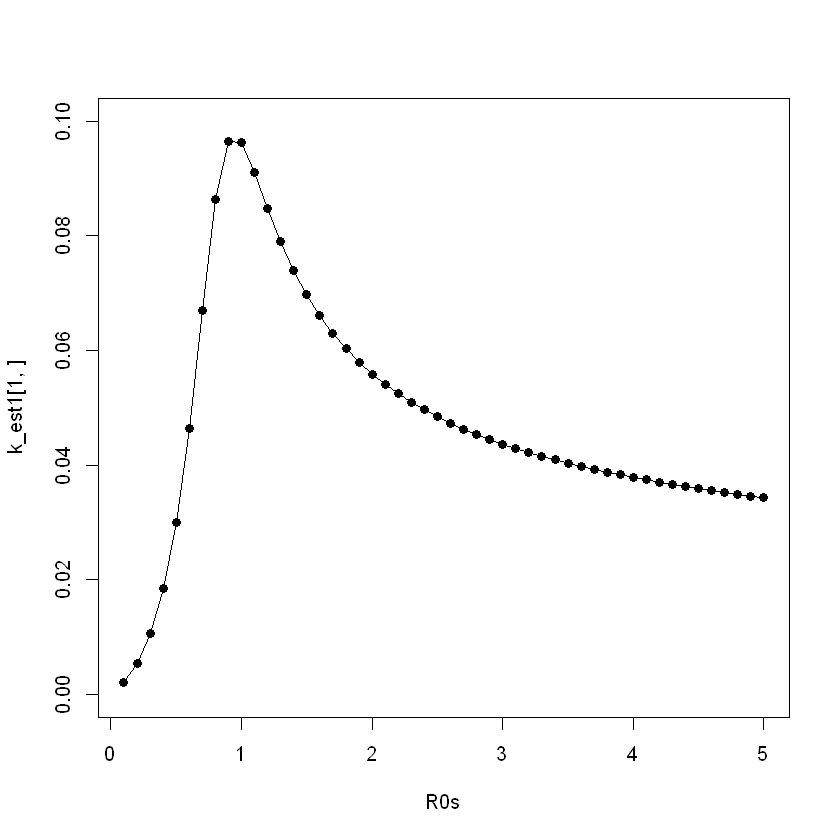

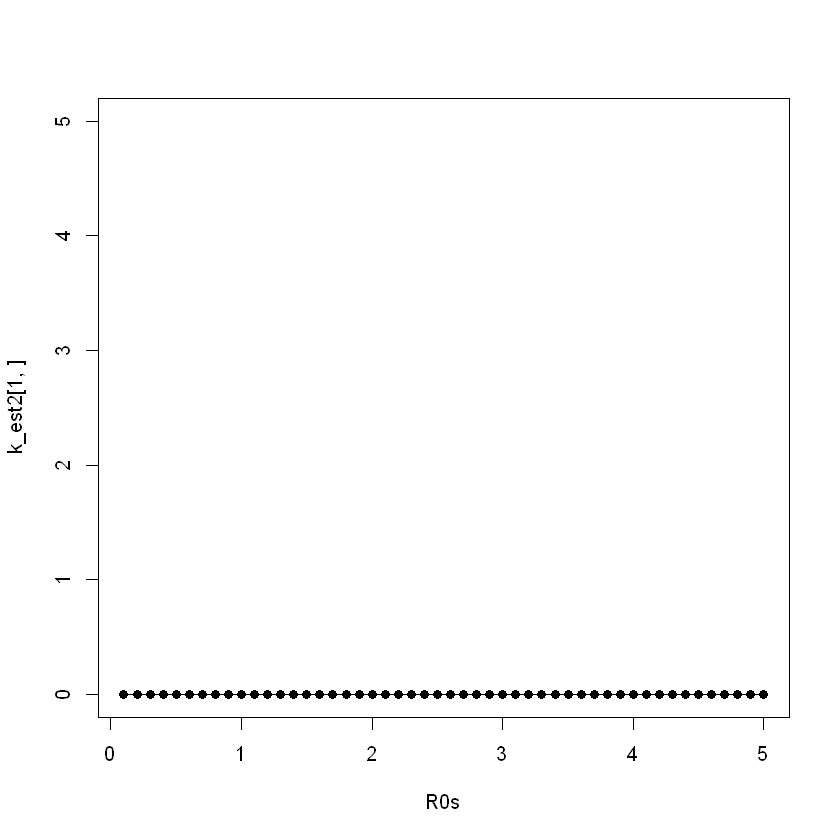

In [10]:
###### Optimise
#opt=optim(fn=lltotal,par=c(1,1),method="L-BFGS",lower=c(1e-2,1e-2),upper=c(10,10),icases=icases,lcases=lcases,isextinct=isextinct,control=list(fnscale=-1))
estimatek_truncate<-function(R0){
    opt=optim(fn=lltotal1_R0,par=1,method="Brent",lower=0,upper=500,icases=icases,lcases=lcases,isextinct=isextinct,R0=R0,control=list(fnscale=-1,trace=1))
    c(1/opt$par,opt$value)
}
estimatek_ongoing<-function(R0){
    opt=optim(fn=lltotal2_R0,par=1,method="Brent",lower=0,upper=500,icases=icases,lcases=lcases,ocases=ocases,isextinct=isextinct,R0=R0,control=list(fnscale=-1,trace=1))
    c(1/opt$par,opt$value)
}
R0s=seq(0.1,5,0.1)
k_est1=suppressWarnings(sapply(R0s,estimatek_truncate))
plot(x=R0s,y=k_est1[1,],ylim=c(0,0.1),type="o",pch=19,xlab="reproduction number",ylab="overdispersion")
#par(new=T);plot(k_est[2,],ylim=c(-50,0))

k_est2=suppressWarnings(sapply(R0s,estimatek_ongoing))
plot(x=R0s,y=k_est2[1,],ylim=c(0,5),type="o",pch=19)

In [ ]:
# MCMC
library(LaplacesDemon)
Data=Data=list(N=13,mon.names=c("nlogl","R0"),parm.names="overdispersion k",R0=1,icases=icases,lcases=lcases,ocases=ocases,isextinct=isextinct)
Model1=function(parm,Data){
    invk=interval(parm,0)
    ll=lltotal1_R0(invk,Data$icases,Data$lcases,Data$isextinct,Data$R0)
    return(list(LP=ll,Dev=-2*ll,Monitor=c(ll,Data$R0),yhat=NULL,parm=invk))
}
Model2=function(parm,Data){
    invk=interval(parm,0)
    ll=lltotal2_R0(invk,Data$icases,Data$lcases,Data$ocases,Data$isextinct,Data$R0)
    return(list(LP=ll,Dev=-2*ll,Monitor=c(ll,Data$R0),yhat=NULL,parm=invk))
}
#fit<-LaplacesDemon(Model=Model,Data=Data,Initial.Values=1,Covar=NULL,Iterations=10000,Status=1000,Thinning=10,Algorithm='HARM',Specs=NULL)

R0s=1:25/5
niter=1000
mcmcfits=sapply(R0s,function(R0){
    Data$R0=R0
    fit=LaplacesDemon(Model=Model1,Data=Data,Initial.Values=1,Covar=NULL,Iterations=niter,Status=niter,Thinning=10,Algorithm='HARM',Specs=list(alpha.star=0.23,B=NULL))
})
k_mcmc1=sapply(mcmcfits,function(x){x$Posterior1[(niter%/%20):(niter%/%10)]})
ll_mcmc1=sapply(mcmcfits,function(x){x$Posterior1[(niter%/%20):(niter%/%10)]})          
#k_est2=sapply(R0s,function(R0){
#    Data$R0=R0
#    fit=LaplacesDemon(Model=Model2,Data=Data,Initial.Values=1,Covar=NULL,Iterations=niter,Status=niter,Thinning=10,Algorithm='HARM',Specs=list(alpha.star=0.23,B=NULL))
#    fit$Posterior1[(niter%/%20):(niter%/%10)]
#})

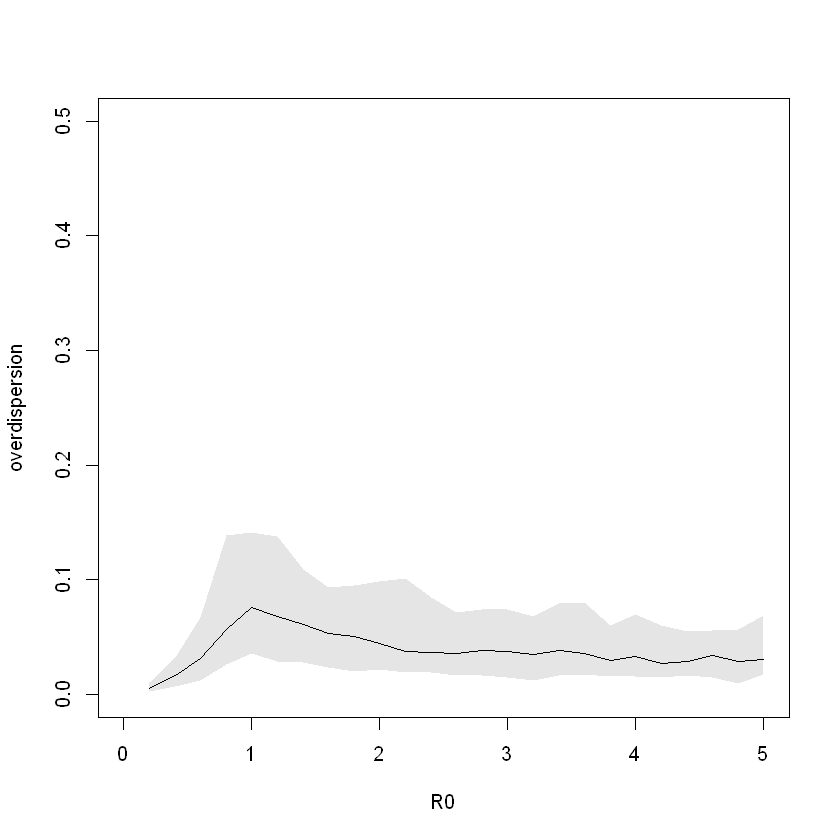

In [48]:
# Plot
med=apply(k_est1,2,median)
cri=apply(k_est1,2,function(x){quantile(x,c(0.025,0.975))})
plot(x=R0s,y=med,xlim=c(0,5),ylim=c(0,0.5),type="l",xlab="R0",ylab="overdispersion")
polygon(x=c(R0s,rev(R0s)),y=c(cri[1,],rev(cri[2,])),lty=0,col=rgb(0,0,0,0.1))

In [46]:
# Joint estimation
Data=Data=list(N=13,mon.names=c("nlogl","R0"),parm.names=c("R0","k"),icases=icases,lcases=lcases,ocases=ocases,isextinct=isextinct)
Model_joint1=function(parm,Data){
    parm=interval(parm,0)
    ll=lltotal1(parm,Data$icases,Data$lcases,Data$isextinct)
    return(list(LP=ll,Dev=-2*ll,Monitor=c(ll,0),yhat=NULL,parm=parm))
}
Model_joint2=function(parm,Data){
    parm=interval(parm,0)
    ll=lltotal2(parm,Data$icases,Data$lcases,Data$ocases,Data$isextinct)
    return(list(LP=ll,Dev=-2*ll,Monitor=c(ll,0),yhat=NULL,parm=parm))
}
#fit<-LaplacesDemon(Model=Model,Data=Data,Initial.Values=1,Covar=NULL,Iterations=10000,Status=1000,Thinning=10,Algorithm='HARM',Specs=NULL)
niter=10000
fit1=LaplacesDemon(Model=Model_joint1,Data=Data,Initial.Values=c(1,1),Covar=NULL,Iterations=niter,Status=niter%/%10,Thinning=10,Algorithm='HARM',Specs=list(alpha.star=0.23,B=NULL))
fit2=LaplacesDemon(Model=Model_joint2,Data=Data,Initial.Values=c(1,1),Covar=NULL,Iterations=niter,Status=niter%/%10,Thinning=10,Algorithm='HARM',Specs=list(alpha.star=0.23,B=NULL))



Laplace's Demon was called on Wed Feb 26 17:59:16 2020

Performing initial checks...
Algorithm: Hit-And-Run Metropolis 

Laplace's Demon is beginning to update...

  Iteration: 14 Proposal:
 c(0.479797913148782,0.768802326608335) 

  Iteration: 15 Proposal:
 c(-0.154856338816527,0.805961477550086) 

  Iteration: 30 Proposal:
 c(0.453627196030345,2.2702892052942) 

  Iteration: 68 Proposal:
 c(0.101421514661351,4.92170238211162) 

  Iteration: 69 Proposal:
 c(0.097403670925914,6.02979573231696) 

  Iteration: 87 Proposal:
 c(0.195380693817257,13.2151158441521) 

  Iteration: 97 Proposal:
 c(-0.190101881801742,11.5606833827604) 

  Iteration: 99 Proposal:
 c(-0.0992938321841439,12.377753241593) 

  Iteration: 116 Proposal:
 c(-0.223207973020654,13.6332592087964) 

  Iteration: 161 Proposal:
 c(0.209430270057254,9.82964780244369) 

  Iteration: 302 Proposal:
 c(0.185309394810876,12.0655324510708) 
Iteration: 1000,   Proposal: Multivariate,   LP: -29.6
Iteration: 2000,   Proposal: Multiva

ERROR: Error in if (any(x < a) | any(x > b)) {: missing value where TRUE/FALSE needed


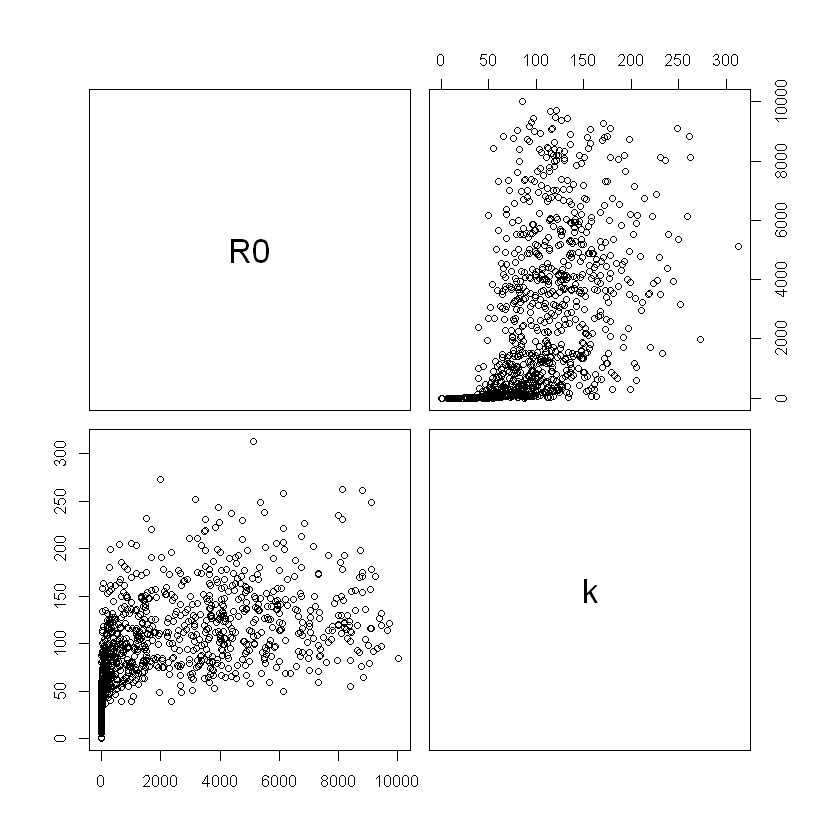

In [47]:
pairs(fit1$Posterior1[,1:2])